In [1]:
!pip install split-folders
!pip install skorch 
!pip install torchsummary

     |████████████████████████████████| 155 kB 885 kB/s            


In [4]:
import os
import warnings
import torchvision
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchsummary import summary
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.helper import predefined_split

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [6]:
print(torch.__version__)

1.9.1


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
data_dir = '../input/brain-tumor-classification-mri'
classes = os.listdir(data_dir + "/Training")

print('Classes:')
for idx, train_class in enumerate(classes):
    print(f'{idx+1}. {train_class}')

Classes:
1. no_tumor
2. pituitary_tumor
3. meningioma_tumor
4. glioma_tumor


In [9]:
size_traning = 0

print('Datasets traning size:')
for idx,train_class in enumerate(classes):
  size  = len(os.listdir(data_dir + f"/Training/{train_class}"))
  size_traning += size
  print(f'{idx+1}. {train_class} {size}')
print(f'Sum {size_traning}')

Datasets traning size:
1. no_tumor 395
2. pituitary_tumor 827
3. meningioma_tumor 822
4. glioma_tumor 826
Sum 2870


In [10]:
size_testing = 0

print('Datasets testing size:')
for idx,test_class in enumerate(classes):
  size  = len(os.listdir(data_dir + f"/Testing/{test_class}"))
  size_testing += size
  print(f'{idx+1}. {test_class} {size}')
print(f'Sum {size_testing}')

Datasets testing size:
1. no_tumor 105
2. pituitary_tumor 74
3. meningioma_tumor 115
4. glioma_tumor 100
Sum 394


In [11]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.9008,0.0992))

Copying files: 2870 files [00:11, 252.29 files/s]


In [12]:
image_size = (224,224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


dataset_training = ImageFolder('./brain-tumor-classification-mri/train', transform=transform)
dataset_validating = ImageFolder('./brain-tumor-classification-mri/val', transform=transform)
dataset_testing = ImageFolder(data_dir+'/Testing', transform=transform)
print(f'Size train {len(dataset_training)}') 
print(f'Size valid {len(dataset_validating)}')
print(f'Size test {len(dataset_testing)}') 

Size train 2583
Size valid 287
Size test 394


In [13]:
img, label = dataset_training[19]
print(f'Input shape: {img.shape}')
print(img)
print(torch.max(img), torch.min(img))

Input shape: torch.Size([3, 224, 224])
tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9765, -0.9765, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9765, -0.9765, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
      

In [15]:
batch_size=32
train_loader = DataLoader(dataset_training ,batch_size=batch_size,shuffle=True,num_workers=4, pin_memory=True)
val_loader =  DataLoader(dataset_validating ,batch_size=batch_size,shuffle=False,num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset_testing,batch_size=batch_size,shuffle=False,num_workers=4, pin_memory=True)

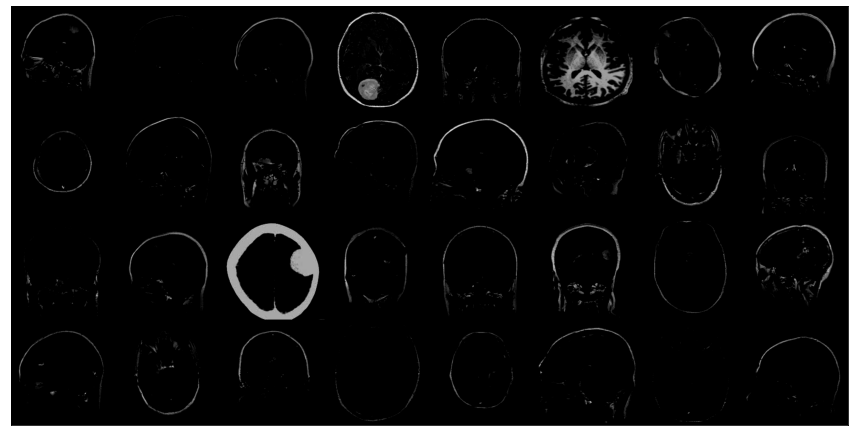

In [16]:
examples = iter(train_loader)
img,labels = examples.next()
def show_batch(dataset_loader):
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img).permute(1, 2, 0))
show_batch(train_loader)

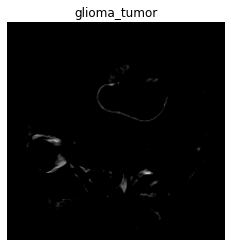

In [18]:
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{dataset_training.classes[label]}')
    plt.axis("off")
    plt.show()

show_image(*dataset_training[11])

In [19]:
y_test = np.array([y for x, y in iter(dataset_testing)])

In [20]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Pytorch and Skorch')
    y_prediction = np.argmax(y_pred, axis=1)
    report = classification_report(y_test, y_prediction, target_names=dataset_training.classes)
    print(f'{report}')
    
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {model} Pytorch and Skorch')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset_training.classes)
    disp.plot(cmap='Blues', ax=ax)

In [21]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                "id": 1,
                "variables":['train_acc', 'valid_acc'],
                "labels":['Training Accuracy', 'Validation Accuracy'],
                "legend":'lower right',
                "title":f'Accuracy Pytorch and Skorch - {model}',
                "ylabel":'Accuracy'
            },{ 
                "id": 2,
                "variables":['train_loss', 'valid_loss'],
                "labels":['Training Loss', 'Validation Loss'],
                "legend":'upper right',
                "title":f'Loss Pytorch and Skorch - {model}',
                "ylabel":'Loss'
            }]
    
    for tab in tab_plot: 
        plt.subplot(1, 2, tab['id'])
        plt.plot(history[:, tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
        plt.plot(history[:, tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
        plt.legend(loc=tab['legend'])
        plt.title(tab['title'])
        plt.xlabel('Epochs')
        plt.ylabel(tab['ylabel'])
    plt.show()

In [22]:
train_acc = EpochScoring(scoring='accuracy', on_train=True, 
                         name='train_acc', lower_is_better=False)
callbacks = [train_acc]

In [65]:
class ModelMmobilenetV2(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.mobilenet_v2(num_classes=output_features, pretrained=False)
        self.model = model

      def forward(self, x):
        return self.model(x)
        
net_mobilenetv2 = NeuralNetClassifier(
    ModelMmobilenetV2,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    iterator_train__num_workers=4, 
    iterator_valid__num_workers=4, 
    iterator_train__pin_memory=True,
    iterator_valid__pin_memory=True,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [66]:
warnings.filterwarnings('ignore')
print('Train Mobilenetv2 Pytorch and Skorch')
net_mobilenetv2.fit(dataset_training, y=None)

Train Mobilenetv2 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.5935        0.9586       0.3310        2.0523  18.5509
      2       0.7216        0.6749       0.7108        0.7583  17.3463
      3       0.7998        0.5191       0.7631        0.5270  17.8148
      4       0.8479        0.3818       0.6794        0.7912  17.4887
      5       0.8738        0.3329       0.8432        0.5117  18.2808
      6       0.9028        0.2693       0.7770        0.7741  17.3513
      7       0.9071        0.2441       0.8606        0.3898  18.1017
      8       0.9485        0.1433       0.5157        1.8029  17.3065
      9       0.9357        0.1725       0.8780        0.3914  17.9361
     10       0.9520        0.1345       0.8467        0.5082  18.0271
     11       0.9667        0.0902       0.8850        0.4336  17.1745
     12       0.9686        0.0994      

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelMmobilenetV2(
    (model): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
     

Test Mobilenetv2 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.18      0.31       100
meningioma_tumor       0.74      0.97      0.83       115
        no_tumor       0.61      0.99      0.76       105
 pituitary_tumor       0.85      0.64      0.73        74

        accuracy                           0.71       394
       macro avg       0.80      0.69      0.66       394
    weighted avg       0.79      0.71      0.66       394



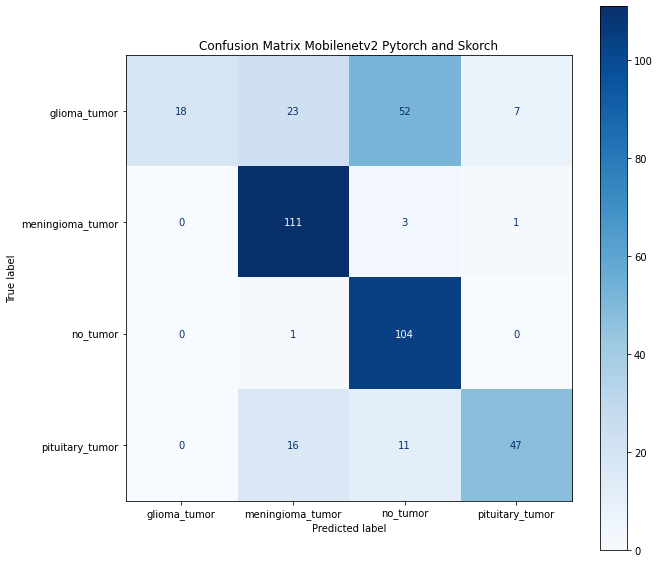

In [72]:
y_pred_mobilenetv2 = net_mobilenetv2.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_mobilenetv2,'Mobilenetv2')

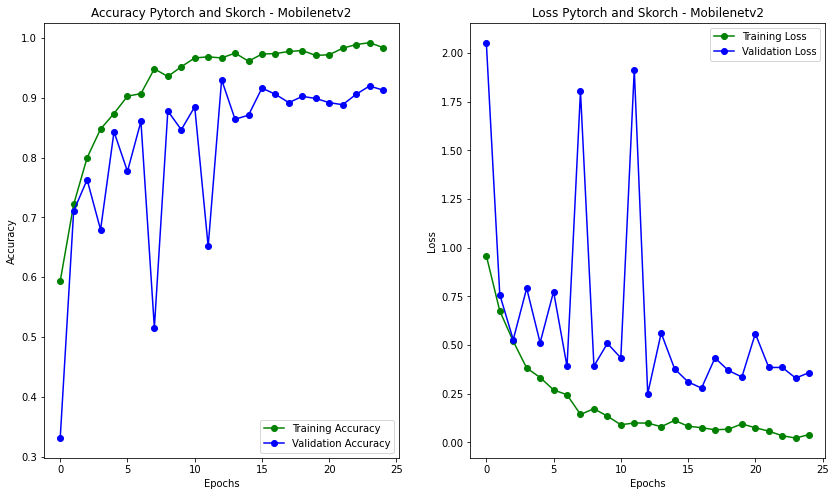

In [71]:
display_plot(net_mobilenetv2.history, 'Mobilenetv2')

In [74]:
class ModelDenseNet121(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.densenet121(num_classes=output_features, pretrained=False)
        self.model = model

      def forward(self, x):
        return self.model(x)
       
net_densenet121 =  NeuralNetClassifier(
    ModelDenseNet121,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    iterator_train__num_workers=4, 
    iterator_valid__num_workers=4, 
    iterator_train__pin_memory=True,
    iterator_valid__pin_memory=True,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [75]:
warnings.filterwarnings('ignore')
print('Train DenseNet121 Pytorch and Skorch')
net_densenet121.fit(dataset_training, y=None)

Train DenseNet121 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.6822        0.7827       0.3554        5.8884  23.4807
      2       0.7844        0.5661       0.1394        7.5852  23.5247
      3       0.8014        0.4868       0.5679        1.3655  23.6300
      4       0.8463        0.4136       0.8049        0.5214  23.1640
      5       0.8839        0.3389       0.3554        3.6916  23.0198
      6       0.8858        0.3022       0.6969        0.7442  23.4628
      7       0.9152        0.2336       0.9094        0.2458  23.7567
      8       0.9032        0.2615       0.8049        0.6360  23.0979
      9       0.9334        0.1892       0.3519        5.6731  23.8098
     10       0.9377        0.1780       0.5157        3.9360  23.5466
     11       0.9404        0.1601       0.4530        5.4169  23.8884
     12       0.9508        0.1467      

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelDenseNet121(
    (model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

Test DenseNet121 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.15      0.26       100
meningioma_tumor       0.61      0.98      0.76       115
        no_tumor       0.72      0.96      0.82       105
 pituitary_tumor       0.82      0.61      0.70        74

        accuracy                           0.70       394
       macro avg       0.79      0.68      0.63       394
    weighted avg       0.78      0.70      0.64       394



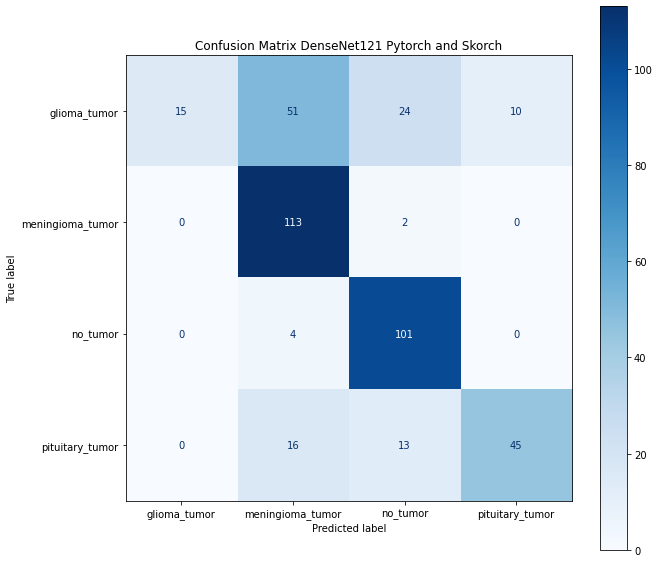

In [76]:
y_pred_densenet121 = net_densenet121.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_densenet121, 'DenseNet121')

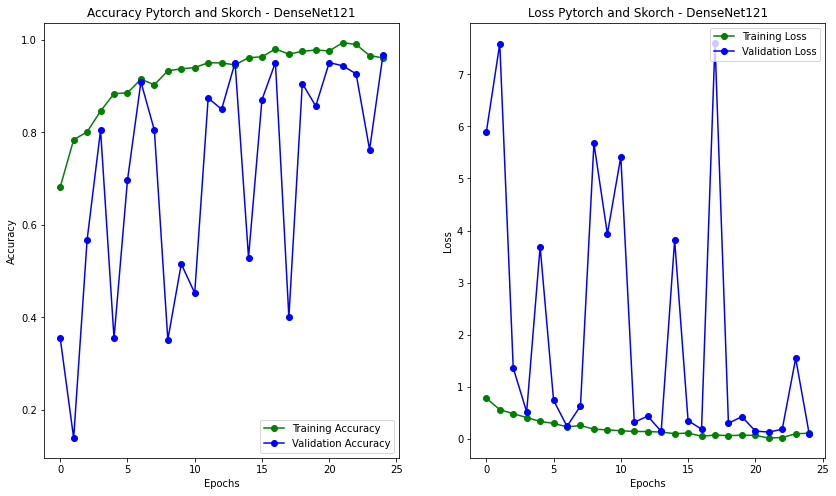

In [77]:
display_plot(net_densenet121.history, 'DenseNet121')

In [46]:
class ModelResnet50(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(num_classes=output_features, pretrained=False)
        self.model = model

      def forward(self, x):
        return self.model(x)

net_resnet50 =  NeuralNetClassifier(
    ModelResnet50,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    iterator_train__num_workers=4, 
    iterator_valid__num_workers=4, 
    iterator_train__pin_memory=True,
    iterator_valid__pin_memory=True,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [47]:
warnings.filterwarnings('ignore')
print('Train Resnet50 Pytorch and Skorch')
net_resnet50.fit(dataset_training, y=None)

Train Resnet50 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.5691        1.1201       0.5052        1.3844  19.5123
      2       0.6988        0.7747       0.7247        0.7570  18.4141
      3       0.7406        0.6486       0.4460        1.8754  19.4858
      4       0.7638        0.6065       0.6446        0.9217  19.7625
      5       0.8173        0.5229       0.3659        3.2669  19.1356
      6       0.8335        0.4534       0.2230        4.2703  19.2599
      7       0.8657        0.3585       0.7143        0.8116  19.3676
      8       0.8811        0.3298       0.7317        0.6578  19.6846
      9       0.8808        0.3457       0.8432        0.4160  19.4637
     10       0.9113        0.2381       0.8223        0.5426  18.4360
     11       0.9226        0.2146       0.8328        0.5376  19.4582
     12       0.9361        0.1805       0.

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelResnet50(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tra

Test Resnet50 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.23      0.37       100
meningioma_tumor       0.74      0.96      0.83       115
        no_tumor       0.63      0.99      0.77       105
 pituitary_tumor       0.91      0.66      0.77        74

        accuracy                           0.73       394
       macro avg       0.80      0.71      0.68       394
    weighted avg       0.79      0.73      0.68       394



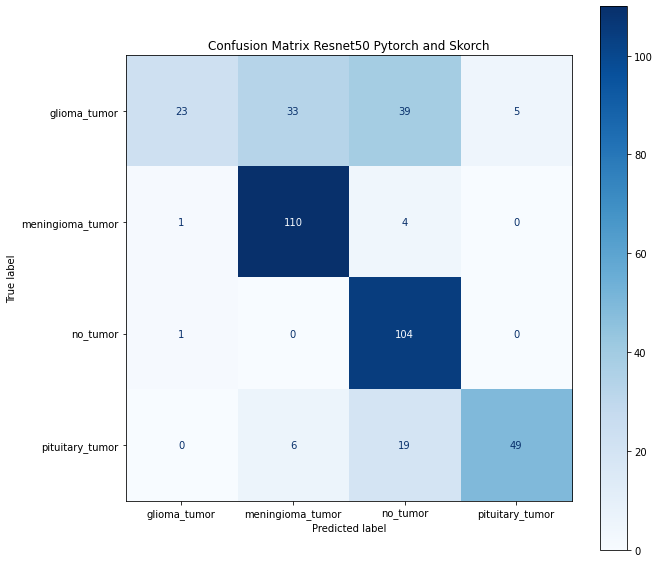

In [48]:
y_pred_resnet50 = net_resnet50.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_resnet50, 'Resnet50')

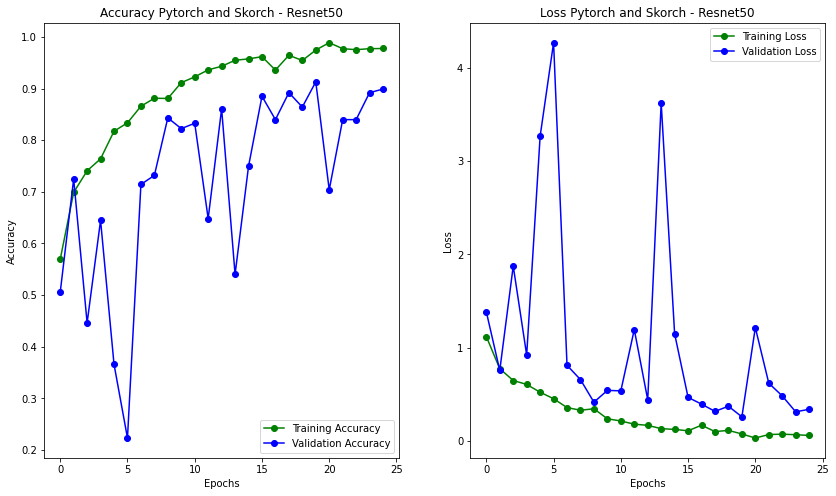

In [49]:
display_plot(net_resnet50.history, 'Resnet50')

In [ ]:
class ModelVgg19(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.vgg19(num_classes=output_features, pretrained=False)
        self.model = model

      def forward(self, x):
        return self.model(x)

net_vgg19 = NeuralNetClassifier(
    ModelVgg19,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [ ]:
warnings.filterwarnings('ignore')
print('Train VGG19 Pytorch and Skorch')
net_vgg19.fit(dataset_training, y=None)

In [ ]:
y_pred_vgg19 = net_vgg19.predict_proba(dataset_testing)
display_report_and_matrix(y_pred_vgg19, 'VGG19')

In [ ]:
display_plot(net_vgg19.history, 'VGG19')